In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from scipy.optimize import curve_fit
from scipy.signal import spectrogram, periodogram, butter, filtfilt
import matplotlib.dates as mdates
from scipy.fft import fftshift
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_predict
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL
from datetime import timedelta
from statsmodels.tsa.stattools import kpss

### Time Series Descomposition

Para este análisis se utiliza el campo GROCERIES I de la tabla de train con el objetivo de simplificar el análisis. 

In [2]:
# Upload datasets
datasets = {}
datasets["oil"] = pd.read_csv("data/oil.csv")
datasets["stores"] = pd.read_csv("data/stores.csv")
datasets["train"] = pd.read_csv("data/train.csv")
datasets["test"] = pd.read_csv("data/test.csv")
datasets["transactions"] = pd.read_csv("data/transactions.csv")
datasets["holidays"] = pd.read_csv("data/holidays_events.csv")

In [3]:
# Transform rows to datetime
for _, dataset in datasets.items():
    if "date" in dataset.columns:
        dataset["date"] = pd.to_datetime(dataset["date"])

In [4]:
family = "GROCERY I"
sales_per_day_dataset = datasets["train"][datasets["train"]["family"] == family].groupby(datasets["train"]['date'].dt.date).sum()["sales"]


In [5]:

sales_per_day_dataset.index = pd.to_datetime(sales_per_day_dataset.index)

### Check for missing values

Se imputan los datos faltantes interpolando entre dos puntos vecinos

In [6]:
def impute_interpolation(dataset, missing):
      time_change = timedelta(days=1)
      dataset[(missing[0] + time_change).strftime('%Y-%m-%d')]
      for miss in missing:
            dataset.loc[miss] = (dataset[miss + time_change] + dataset[miss - time_change]) / 2
      return dataset

In [7]:

my_range = pd.date_range(start="2013-01-01", end="2017-08-15", freq='B')
difference = my_range.difference(sales_per_day_dataset.index)
print(difference)

dataset = impute_interpolation(sales_per_day_dataset, difference)

DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25'], dtype='datetime64[ns]', freq=None)


In [8]:
sales_per_day_dataset = sales_per_day_dataset.sort_index()
sales_per_day = sales_per_day_dataset[:1600]
sales_per_day_test = sales_per_day_dataset[1600:]

In [9]:
sales_per_day

date
2013-01-01       700.000
2013-01-02    202020.000
2013-01-03    144878.000
2013-01-04    135754.000
2013-01-05    188356.000
                 ...    
2017-05-16    241186.132
2017-05-17    242271.766
2017-05-18    189992.941
2017-05-19    225889.530
2017-05-20    314630.342
Name: sales, Length: 1600, dtype: float64

In [10]:
print(sales_per_day.loc["2013-12-25"])

sales_per_day

217349.0


date
2013-01-01       700.000
2013-01-02    202020.000
2013-01-03    144878.000
2013-01-04    135754.000
2013-01-05    188356.000
                 ...    
2017-05-16    241186.132
2017-05-17    242271.766
2017-05-18    189992.941
2017-05-19    225889.530
2017-05-20    314630.342
Name: sales, Length: 1600, dtype: float64

### Autocorrelation

Se grafica la función de autocorrelación muestreal

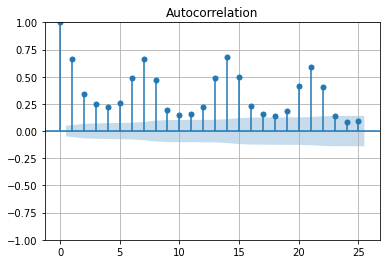

In [11]:
rcParams['figure.figsize'] = 10, 6
plot_acf(sales_per_day.values, lags=25)
plt.grid()
plt.show()

Se hace un análisis de la serie de tiempo para determinar si la serie es estacionario. Se hace utiliza el test de Dickey-Fuller.

In [12]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [13]:
adf_test(sales_per_day.values)

Results of Dickey-Fuller Test:
Test Statistic                   -3.875394
p-value                           0.002224
#Lags Used                       22.000000
Number of Observations Used    1577.000000
Critical Value (1%)              -3.434503
Critical Value (5%)              -2.863374
Critical Value (10%)             -2.567747
dtype: float64


El test de dicky fuller nos dice que la serie es estacionaria

In [14]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

kpss_test(sales_per_day.values)

Results of KPSS Test:
Test Statistic            5.845239
p-value                   0.010000
Lags Used                20.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\Users\gonza\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


El test de kpss nos dice que la serie no es estacionaria

Se grafica la función de autocorrelación parcial

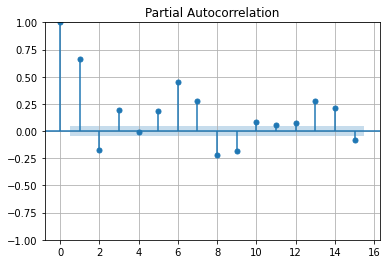

In [15]:
plot_pacf(sales_per_day.values, lags=15, method="ywm")
plt.grid()
plt.show()

### Additive descomposition

Posteriormente se realiza la descomposición de la serie de tiempo usando seasonal_decompose de forma aditiva

<Figure size 1440x4320 with 0 Axes>

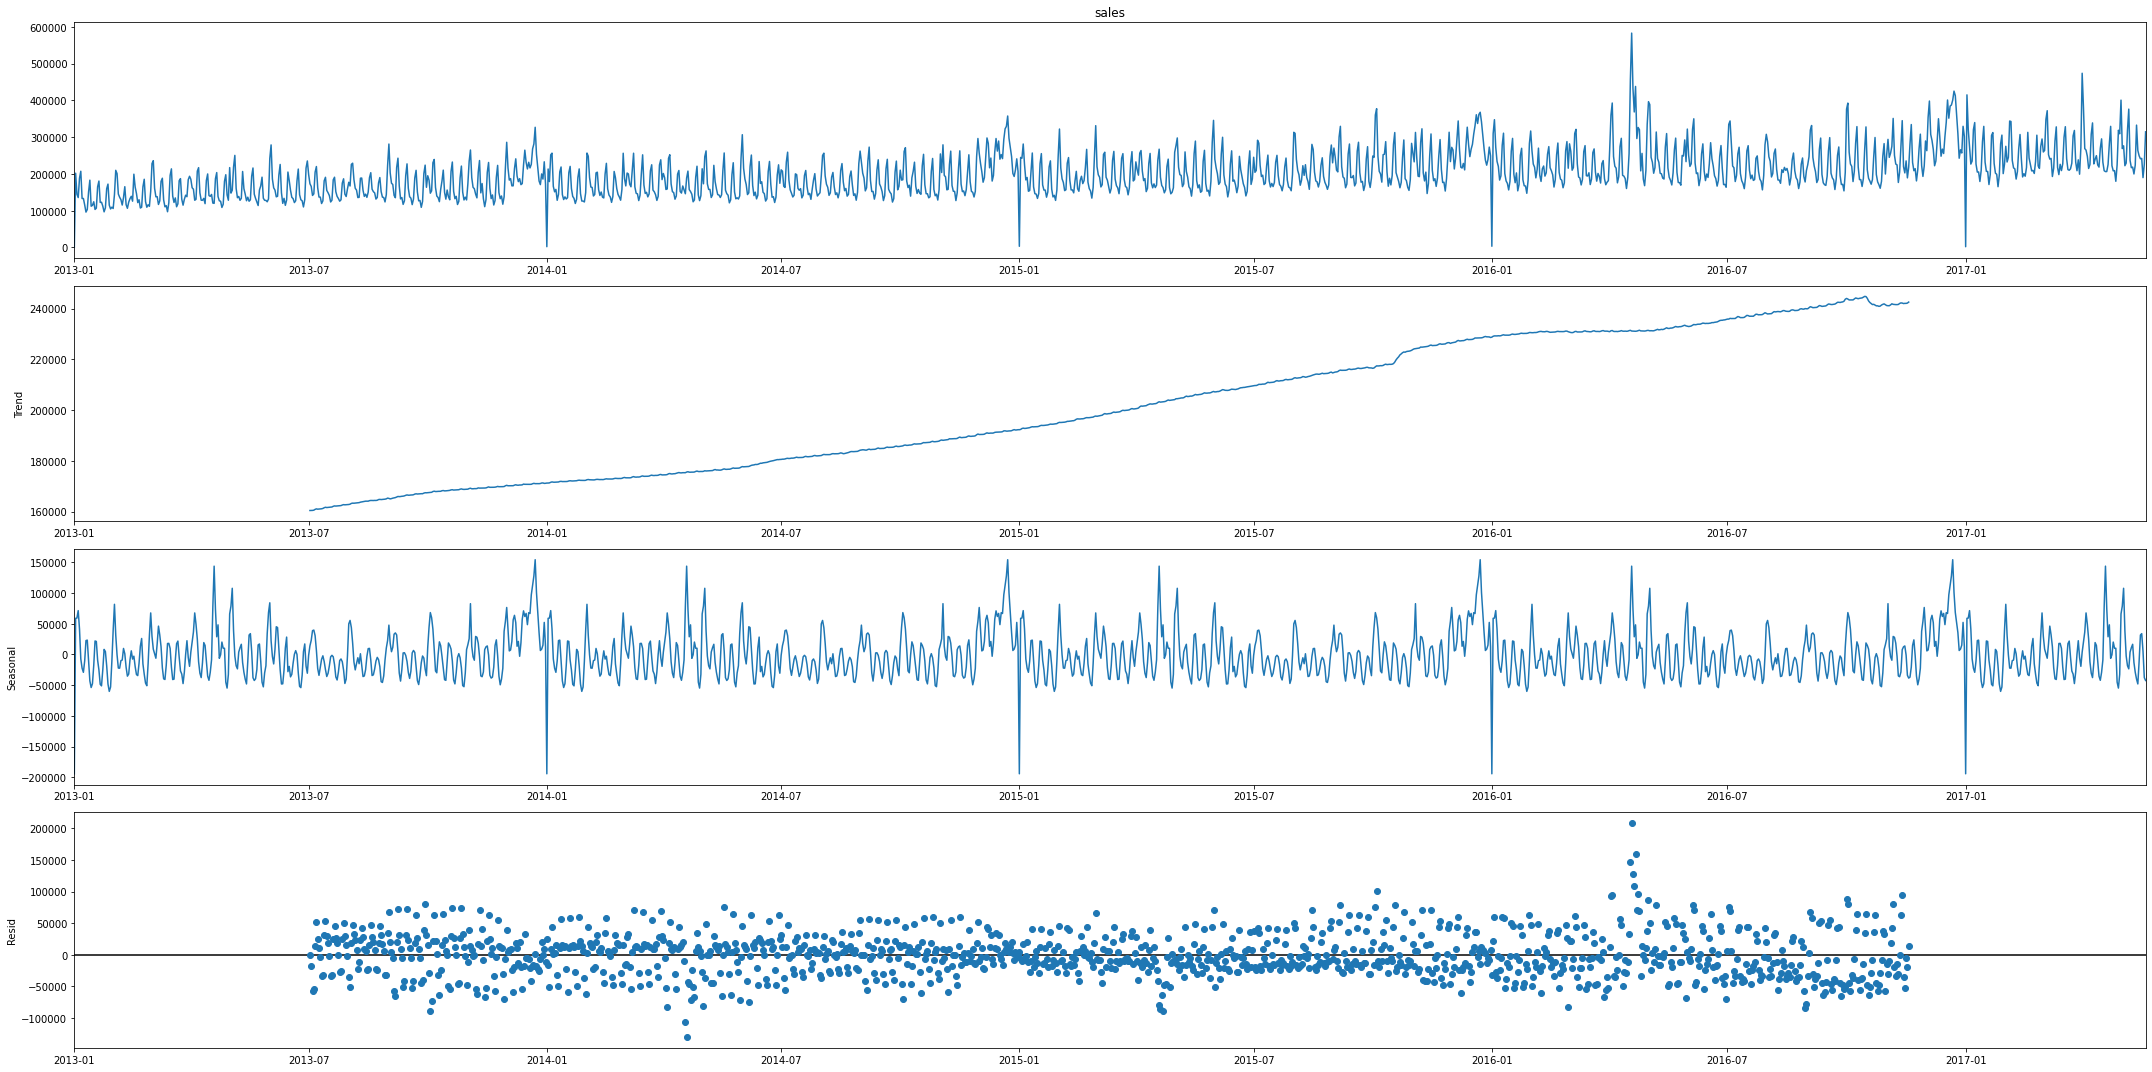

<Figure size 1440x4320 with 0 Axes>

In [16]:
result = seasonal_decompose(sales_per_day, model='additive', period=365)
 
rcParams['figure.figsize'] = 30, 15
result.plot()
plt.figure(figsize=(20, 60))

### Multiplicative descomposition

Luego se hace la descomposición de forma multiplicativa

<Figure size 1440x4320 with 0 Axes>

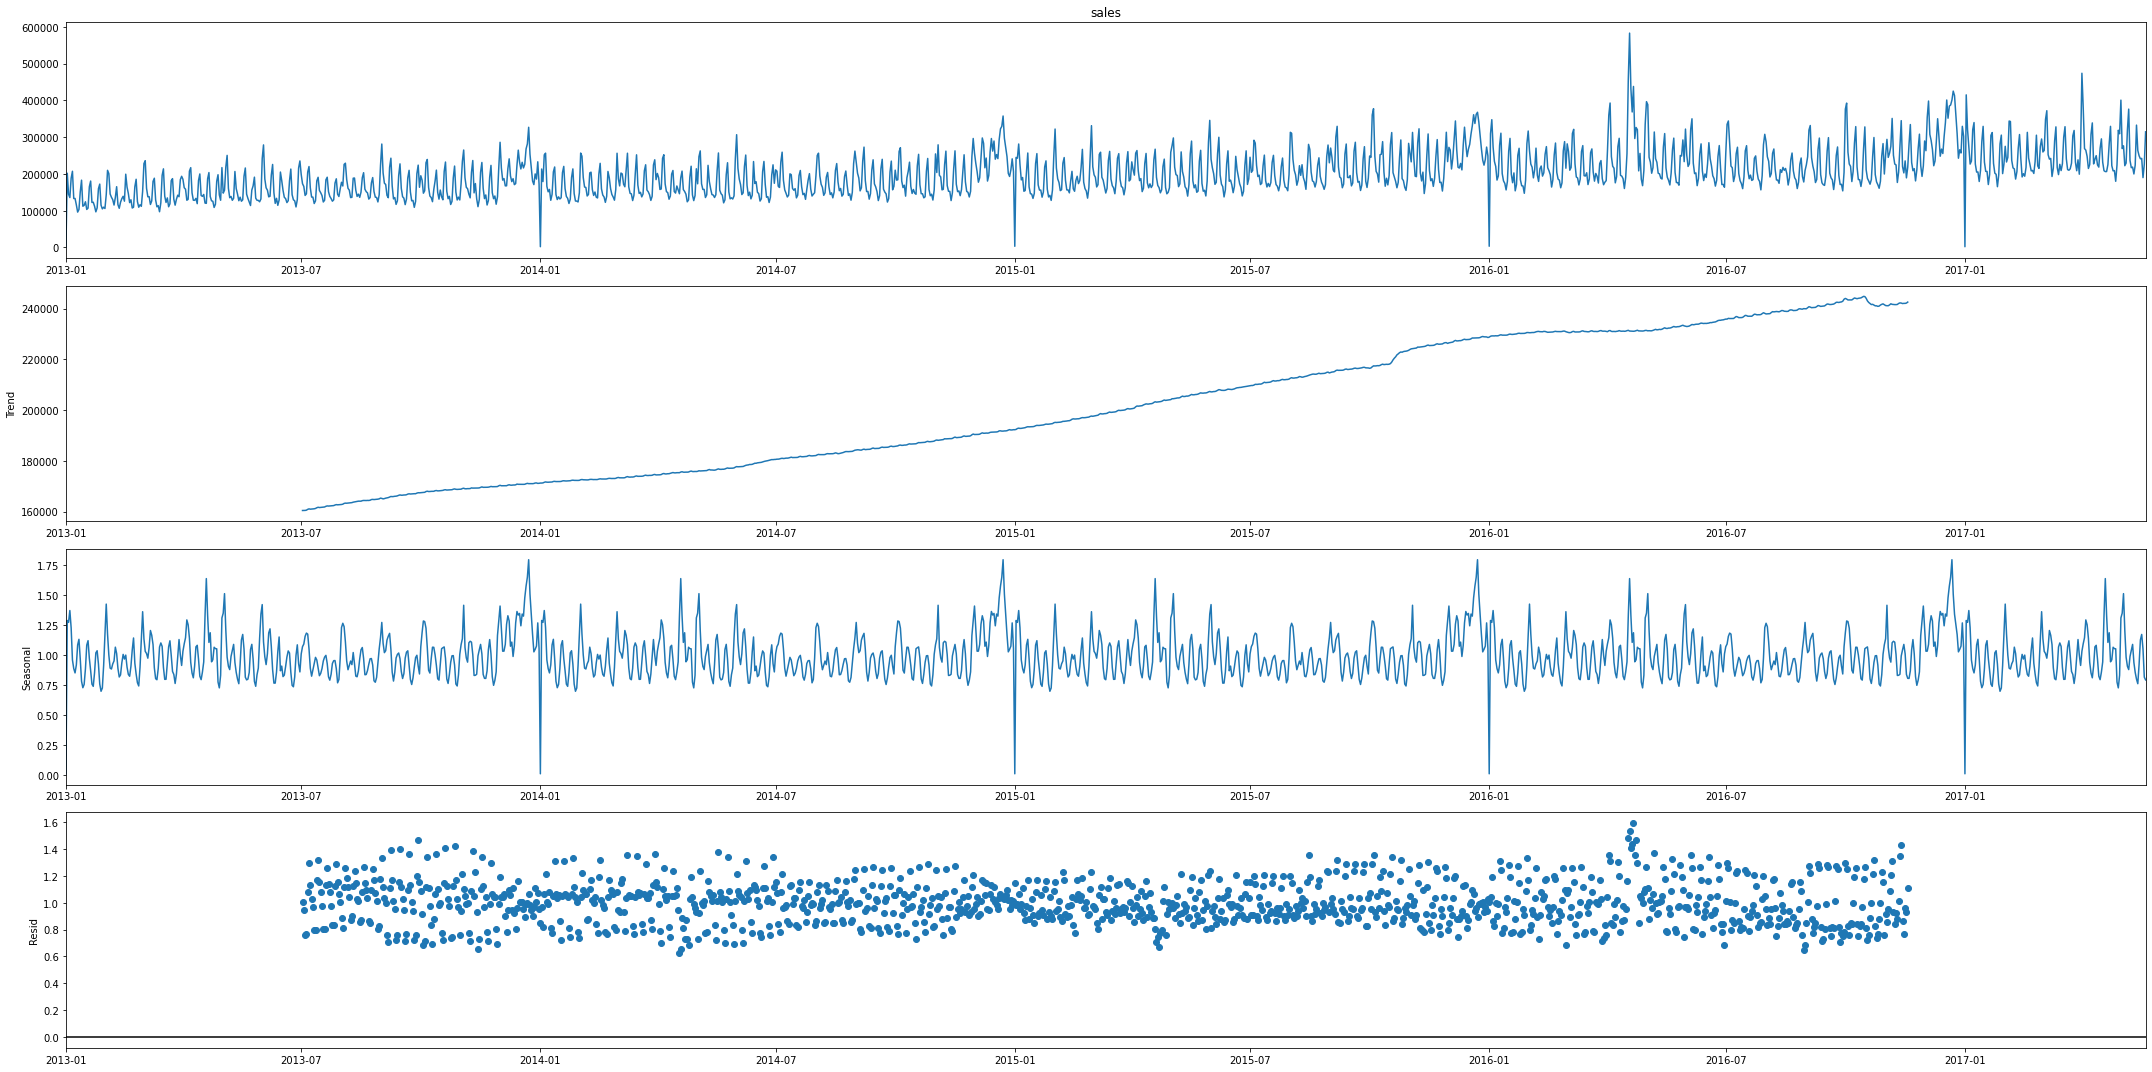

<Figure size 1440x4320 with 0 Axes>

In [17]:
result = seasonal_decompose(sales_per_day, model='multiplicative', period=365)
 
rcParams['figure.figsize'] = 30, 15
result.plot()
plt.figure(figsize=(20, 60))

### Descomposition using LOESS

<Figure size 1440x4320 with 0 Axes>

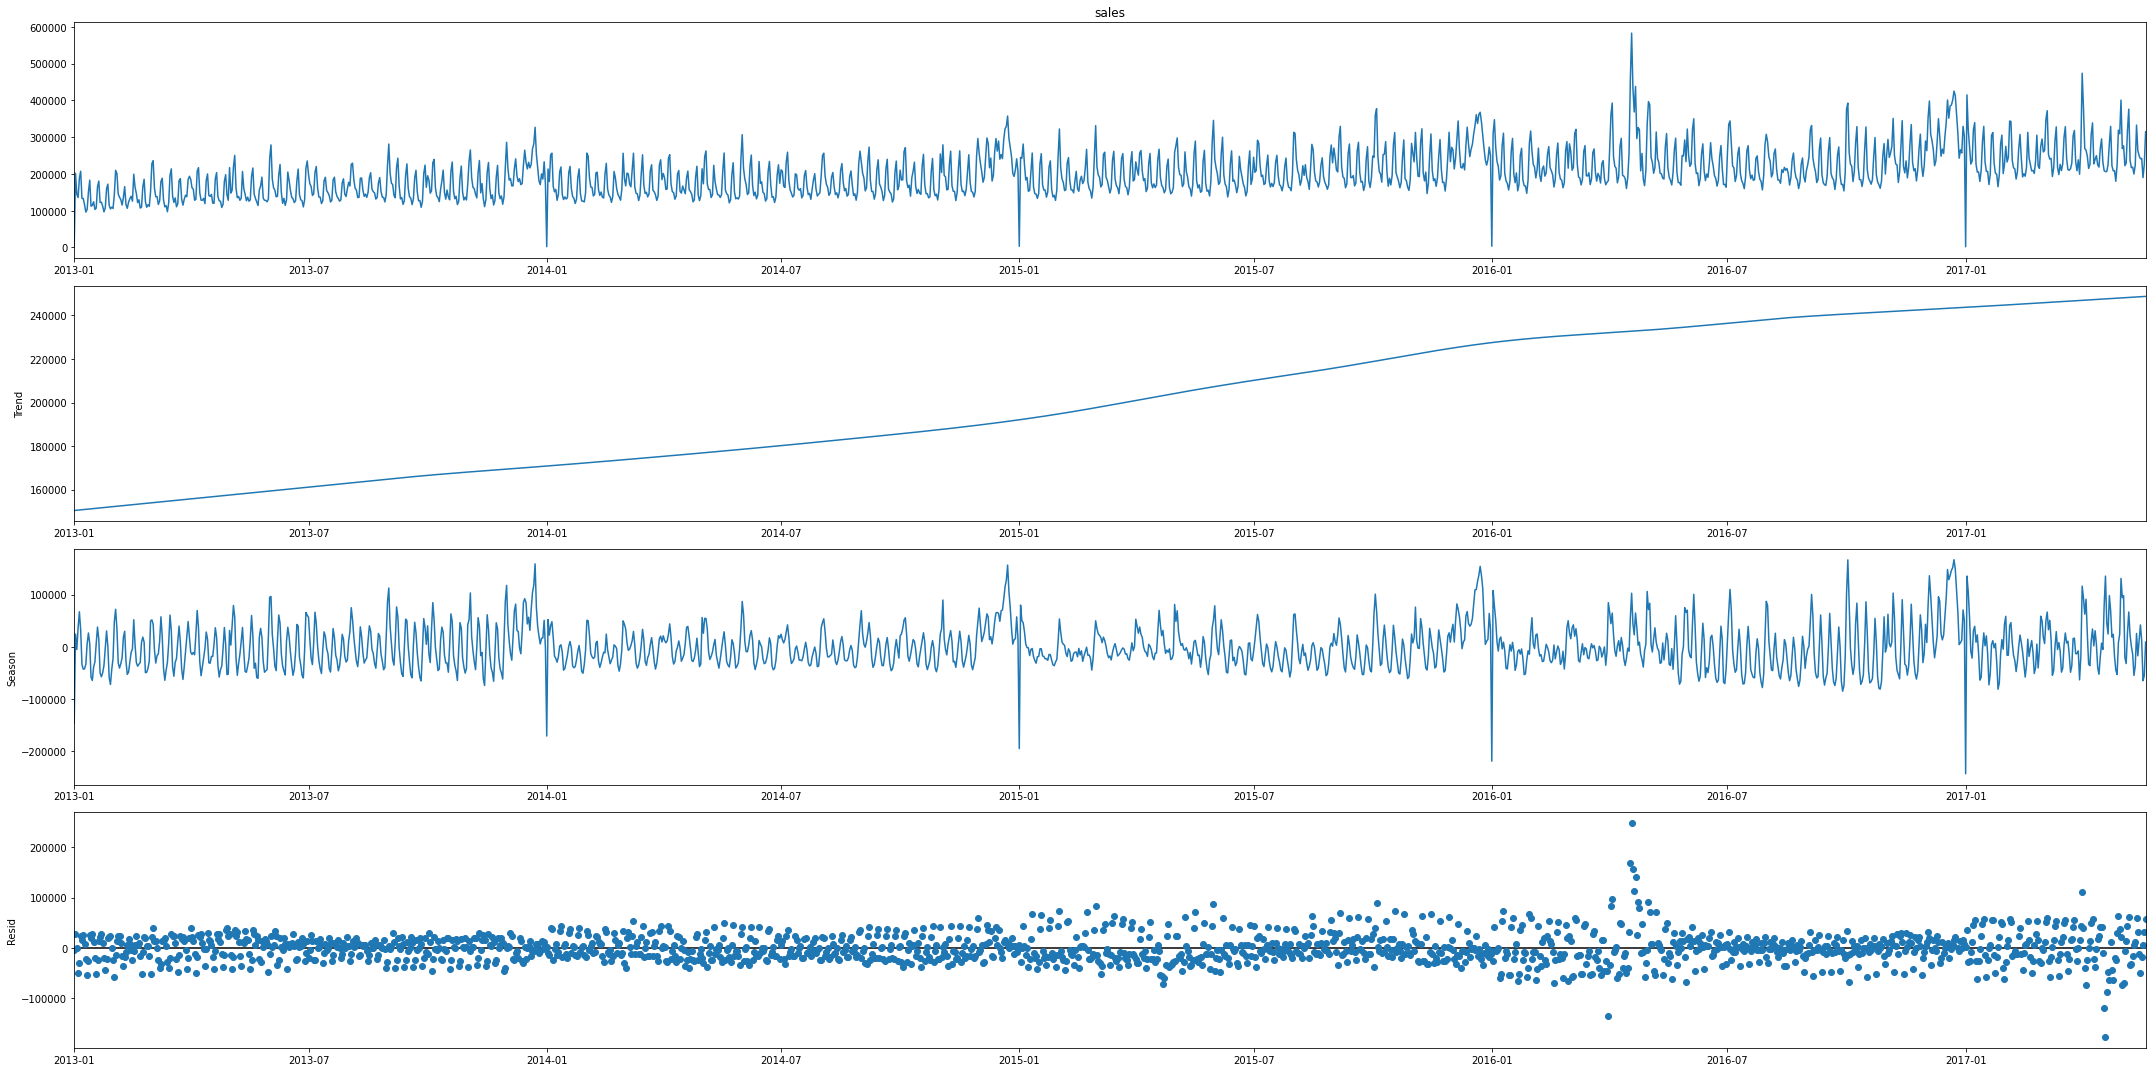

<Figure size 1440x4320 with 0 Axes>

In [18]:
res = STL(sales_per_day, period=365, seasonal=365).fit()
res.plot()
plt.figure(figsize=(20, 60))

### Trend

Se obtiene la tendencia a través de mínimos cuadrados

In [19]:

def plot_trend(series, model="linear"):

    if model == "cuadratic":
        def objective(x, a, b, c):
            return a * x + b * x ** 2 + c
    else:
        def objective(x, a, b):
            return a * x + b

    x = mdates.date2num(series.index)
    y = series.values

    popt, _ = curve_fit(objective, x, y)
    print(f"Model coefficients {popt}")


    x_line = np.arange(min(x), max(x), 1)
    print(len(x_line))
    print(len(series.index))
    print(len(mdates.date2num(series.index)))
    y_line = objective(x_line, *popt)

    plt.figure(figsize=(20, 10))
    plt.grid()
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.plot(x_line, y_line)
    plt.plot(x, y)
    return y_line, popt


    

Model coefficients [ 7.31262952e+01 -1.00557910e+06]
1600
1600
1600


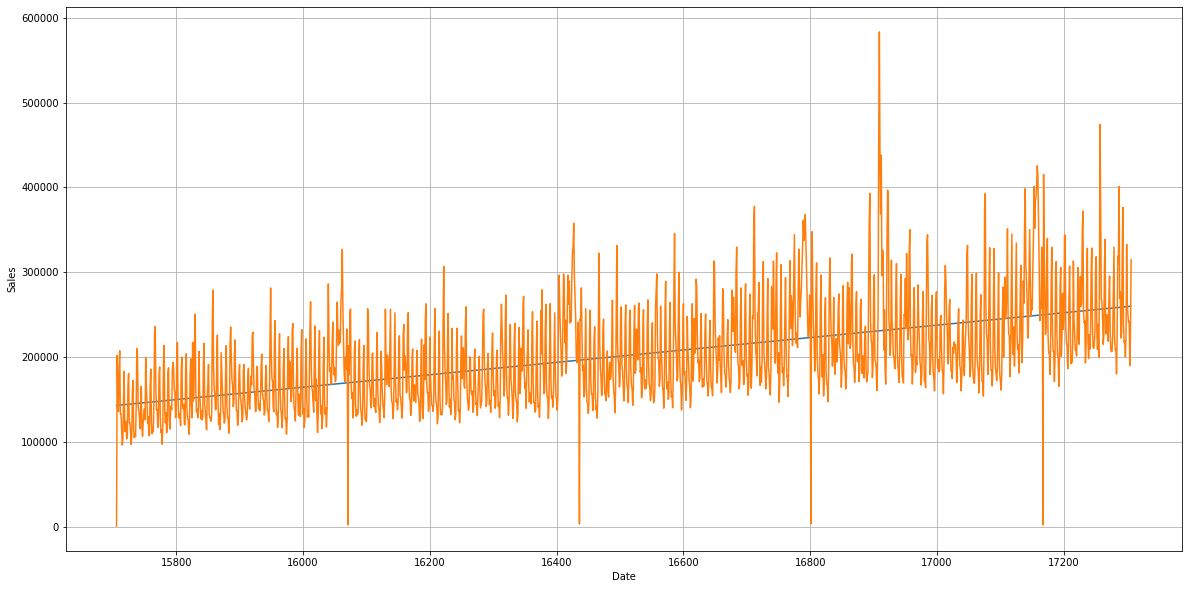

In [20]:
tendency, popt = plot_trend(sales_per_day)

In [21]:
#plot_trend(sales_per_day, model="cuadratic")

Se elimina la tendencia de la serie

In [22]:
sales_per_day = sales_per_day - tendency

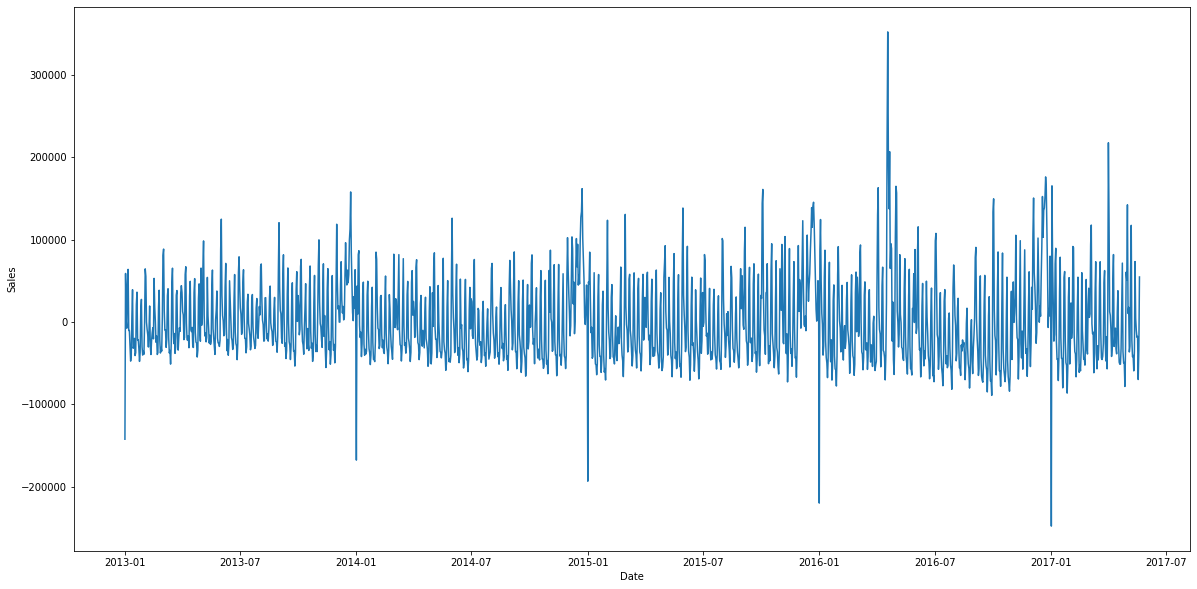

In [23]:
plt.figure(figsize=(20, 10))
plt.xlabel("Date")
plt.ylabel("Sales")
plt.plot(sales_per_day)

<Figure size 1440x720 with 0 Axes>

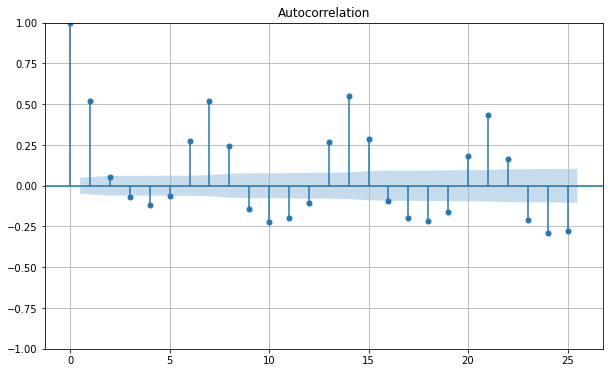

In [24]:
#plot_acf((sales_per_day + sales_per_day.shift(4)).dropna().values, lags=25)
rcParams['figure.figsize'] = 10, 6
plt.figure(figsize=(20, 10))
plot_acf(sales_per_day.values, lags=25)
plt.grid()
plt.show()

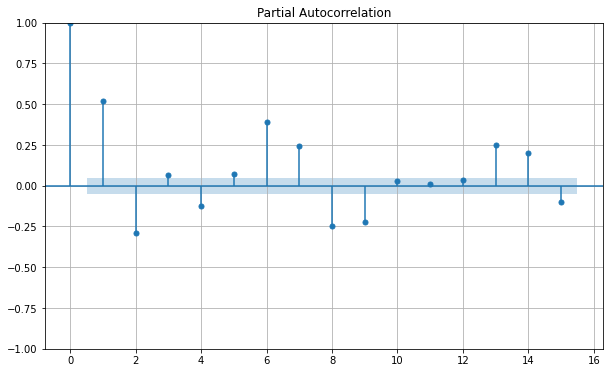

In [25]:
plot_pacf(sales_per_day.values, lags=15, method="ywm")
plt.grid()
plt.show()


In [26]:
#plot_pacf(sales_per_day.diff().values[1:], lags=15, method="ywm")
#plt.grid()
#plt.show()

In [27]:
adf_test(sales_per_day.values)

Results of Dickey-Fuller Test:
Test Statistic                -7.905738e+00
p-value                        4.071444e-12
#Lags Used                     2.200000e+01
Number of Observations Used    1.577000e+03
Critical Value (1%)           -3.434503e+00
Critical Value (5%)           -2.863374e+00
Critical Value (10%)          -2.567747e+00
dtype: float64


In [28]:
kpss_test(sales_per_day.values)

Results of KPSS Test:
Test Statistic           0.068413
p-value                  0.100000
Lags Used                7.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


c:\Users\gonza\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Según el test de dickey fuller y kpss la serie es estacionaria  al eliminarle la tendencia

### Cycle

Se grafica el periodograma de la serie

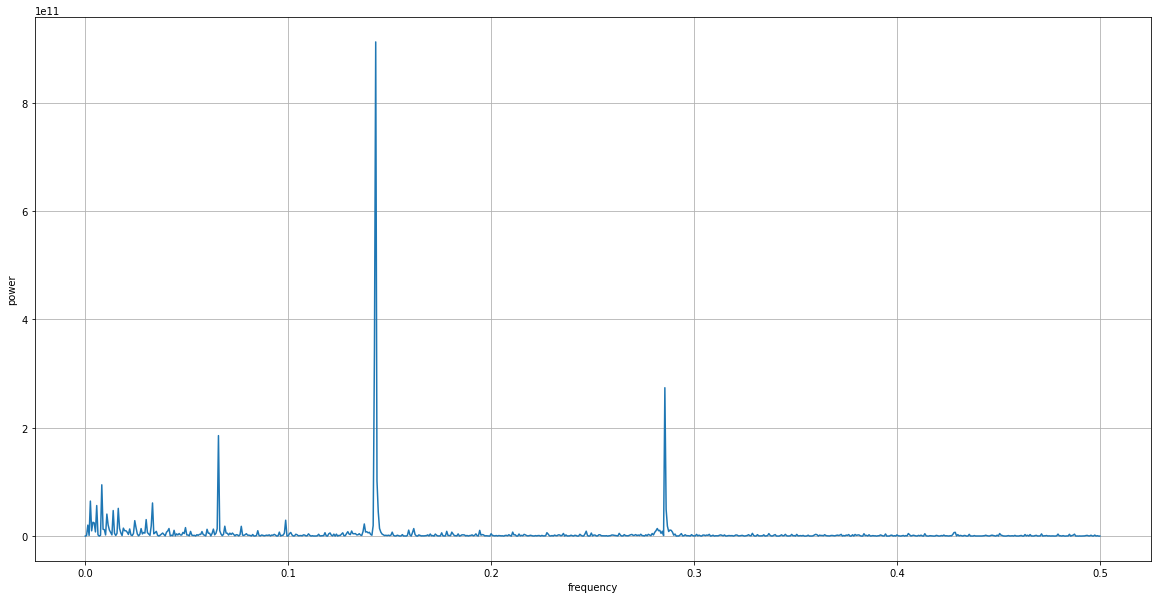

In [29]:
freq, power  = periodogram(sales_per_day.values)
plt.figure(figsize=(20, 10))
plt.grid()
plt.xlabel("frequency")
plt.ylabel("power")
plt.plot(freq, power)


Puede observarse una componenente semanal bastante marcada. Se observan picos a periodos de 3,5 días y dos semanas.

Se obtiene el espectrograma

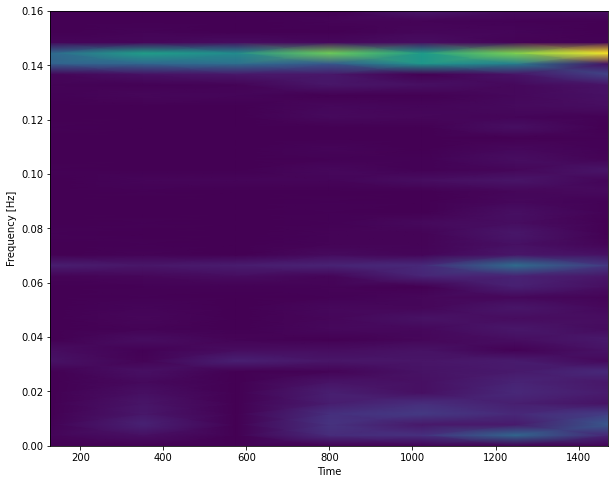

In [30]:
#<plt.plot(spectrogram(sales_per_day.values))
f, t, Sxx = spectrogram(sales_per_day.values)

plt.figure(figsize=(10, 8))
plt.pcolormesh(t, fftshift(f), fftshift(Sxx, axes=0), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time')
plt.ylim([0, 0.16])
plt.show()

Se puede observar en el espectrograma que se produce ciclos a una frecuencia de aproximadamente 0.14 Hz, esto corresponde a un ciclo semanal.

In [31]:
#plt.figure(figsize=(10, 8))
#powerSpectrum, freqenciesFound, time, imageAxis = plt.specgram(sales_per_day.values, Fs=1, cmap="rainbow")

Se utiliza un filtro pasa banda para determinar la componente cicloidal

In [32]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype="high", analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype="low", analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = [cut / nyq for cut in cutoff]
    b, a = butter(order, normal_cutoff, btype="bandpass", analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y


Se grafica la componente de alta frecuencia

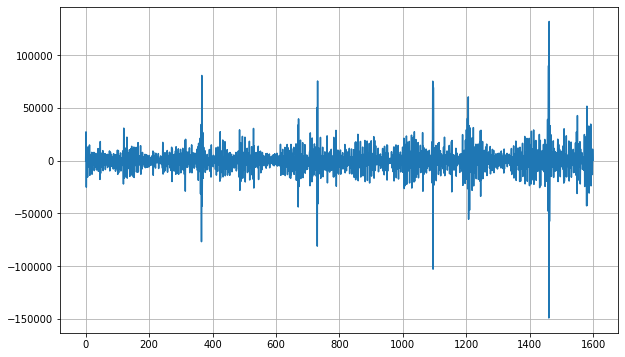

In [33]:
high_filtered_data = butter_highpass_filter(sales_per_day.values, 300, 1000)
plt.grid()
plt.plot(high_filtered_data)

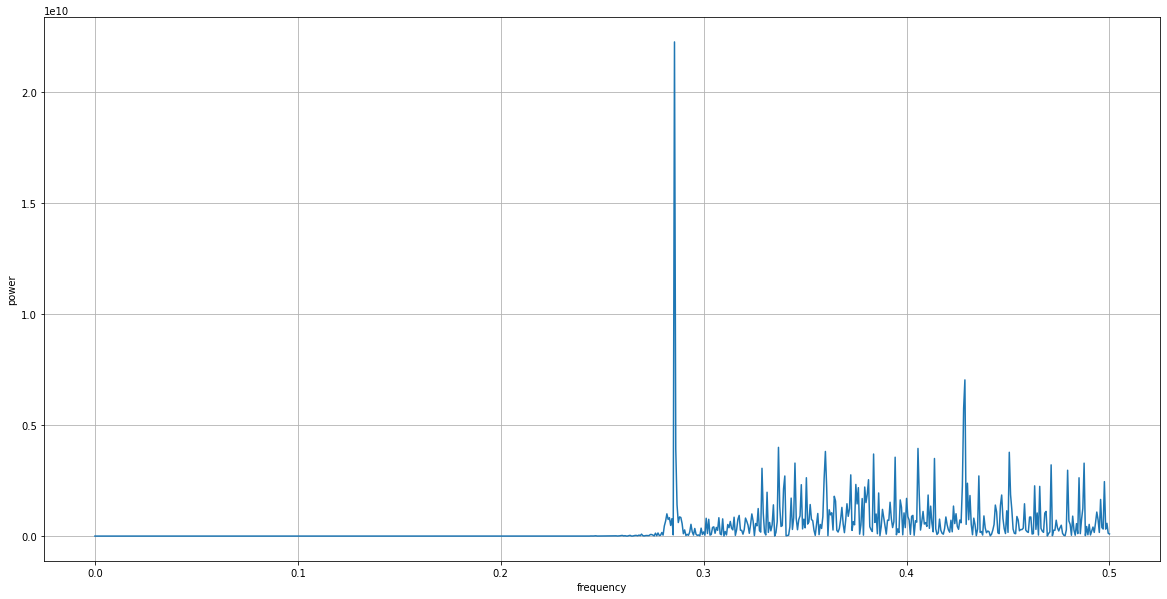

In [34]:
freq, power = periodogram(high_filtered_data)
plt.figure(figsize=(20, 10))
plt.grid()
plt.xlabel("frequency")
plt.ylabel("power")
plt.plot(freq, power)

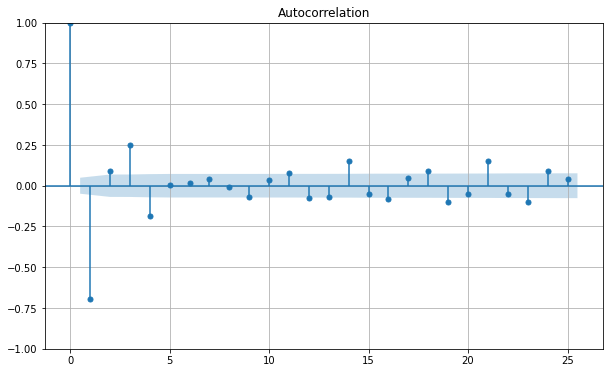

In [35]:
plot_acf(pd.Series(high_filtered_data).dropna(), lags=25)
plt.grid()
plt.show()

c:\Users\gonza\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


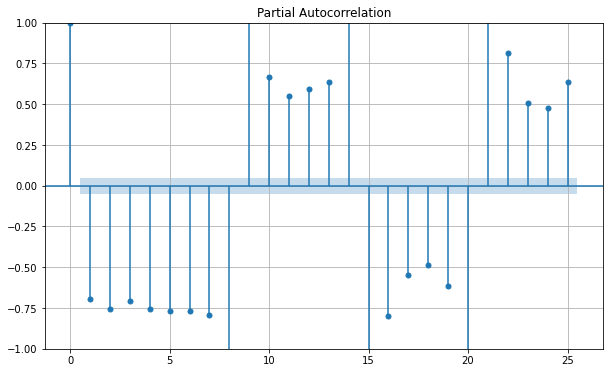

In [36]:
plot_pacf(pd.Series(high_filtered_data).dropna(), lags=25)
plt.grid()
plt.show()

In [37]:
adf_test(high_filtered_data)

Results of Dickey-Fuller Test:
Test Statistic                  -46.396566
p-value                           0.000000
#Lags Used                       24.000000
Number of Observations Used    1575.000000
Critical Value (1%)              -3.434509
Critical Value (5%)              -2.863377
Critical Value (10%)             -2.567748
dtype: float64


In [38]:
kpss_test(high_filtered_data)

Results of KPSS Test:
Test Statistic            0.038431
p-value                   0.100000
Lags Used                86.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\Users\gonza\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Se grafica la componente de frecuancia semanal

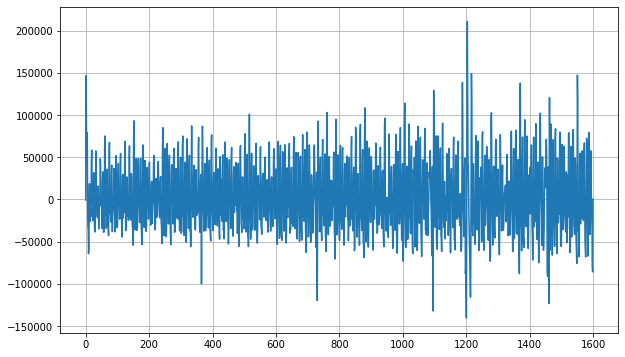

In [39]:
filtered_data = butter_bandpass_filter(sales_per_day.values, [50, 300], 1000)
plt.grid()
plt.plot(filtered_data)

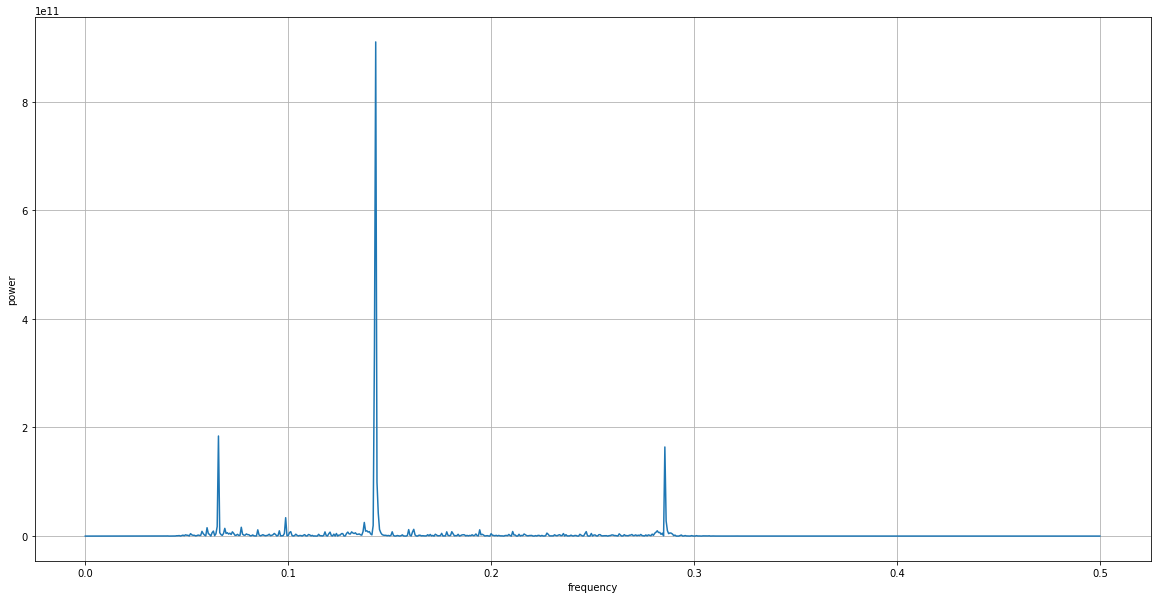

In [40]:
freq, power = periodogram(filtered_data)
plt.figure(figsize=(20, 10))
plt.grid()
plt.xlabel("frequency")
plt.ylabel("power")
plt.plot(freq, power)

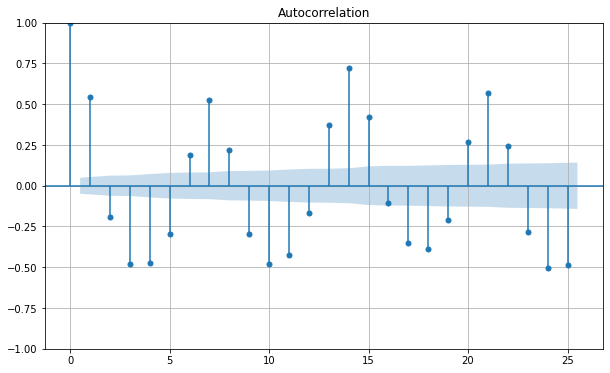

In [41]:

plot_acf(filtered_data, lags=25)

plt.grid()
plt.show()

c:\Users\gonza\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


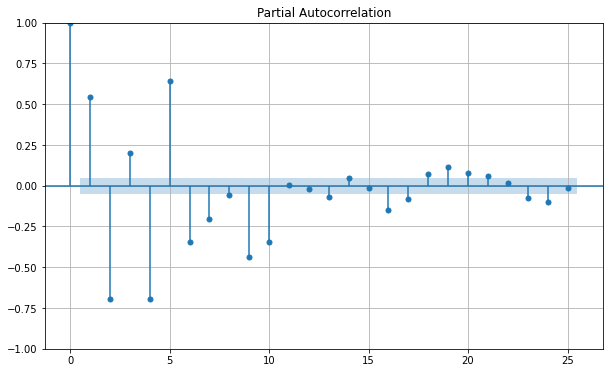

In [42]:
plot_pacf(filtered_data, lags=25)

plt.grid()
plt.show()

Se grafica la componente de baja frecuencia

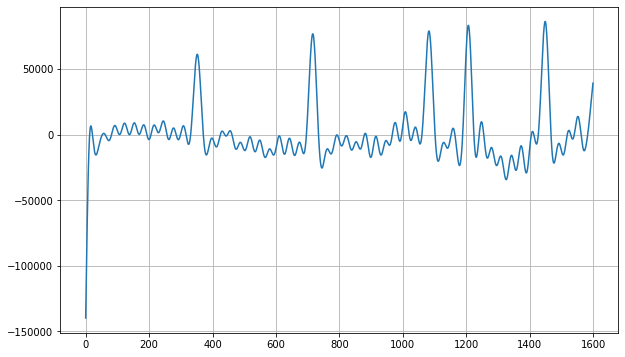

In [43]:
low_filtered_data = butter_lowpass_filter(sales_per_day.values, 30, 1000)
plt.grid()
plt.plot(low_filtered_data)

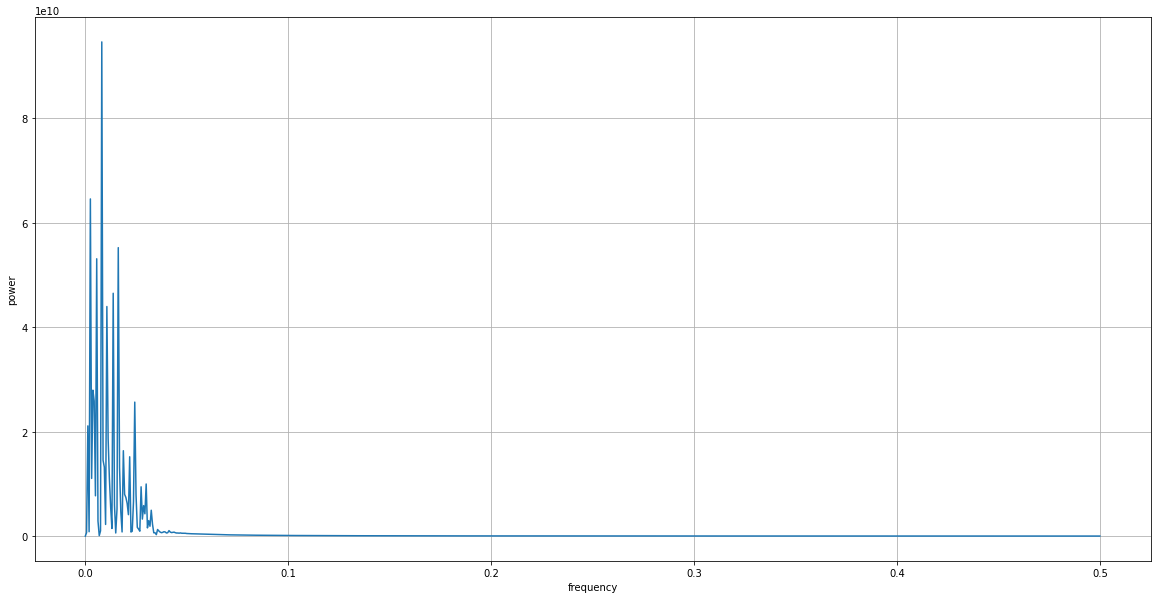

In [44]:
freq, power = periodogram(low_filtered_data)
plt.figure(figsize=(20, 10))
plt.grid()
plt.xlabel("frequency")
plt.ylabel("power")
plt.plot(freq, power)

In [45]:
adf_test(low_filtered_data)

Results of Dickey-Fuller Test:
Test Statistic                -9.092803e+00
p-value                        3.784244e-15
#Lags Used                     1.100000e+01
Number of Observations Used    1.588000e+03
Critical Value (1%)           -3.434475e+00
Critical Value (5%)           -2.863362e+00
Critical Value (10%)          -2.567740e+00
dtype: float64


In [46]:
kpss_test(low_filtered_data)

Results of KPSS Test:
Test Statistic            0.05721
p-value                   0.10000
Lags Used                25.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


c:\Users\gonza\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


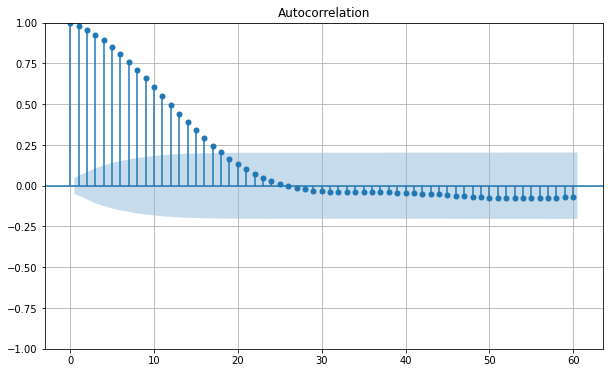

In [47]:
plot_acf(low_filtered_data, lags=60)
#plot_acf((pd.Series(low_filtered_data) - pd.Series(low_filtered_data).shift(1)).dropna().values, lags=25)
plt.grid()
plt.show()

c:\Users\gonza\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


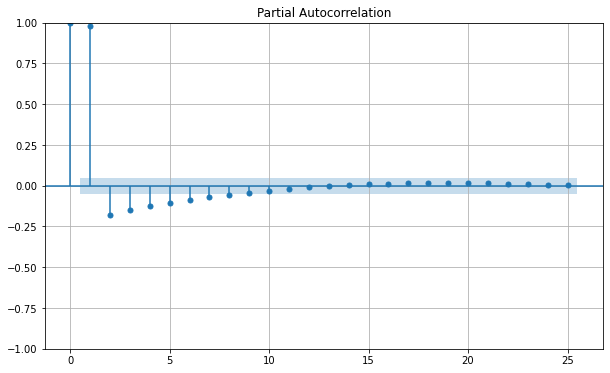

In [48]:
#plot_pacf(low_filtered_data, lags=25)
plot_pacf((pd.Series(low_filtered_data)).dropna().values, lags=25)
plt.grid()
plt.show()

### ARIMA

Se modela la serie usando ARIMA, se obtienen los parámetros a partir de las gráficas de autocorrelación

In [49]:
d = 0
q = 13
p = 6
arima = ARIMA(sales_per_day.values, order=(p, d, q))
arima_res = arima.fit()
print(arima_res.summary())

c:\Users\gonza\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1600
Model:                ARIMA(6, 0, 13)   Log Likelihood              -18811.709
Date:                Sun, 19 Jun 2022   AIC                          37665.417
Time:                        17:39:54   BIC                          37778.350
Sample:                             0   HQIC                         37707.353
                               - 1600                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.6728   3904.786      0.002      0.999   -7646.567    7659.913
ar.L1          0.8997      0.252      3.573      0.000       0.406       1.393
ar.L2         -0.7023      0.421     -1.668      0.0

Se grafican los residuos

<AxesSubplot:>

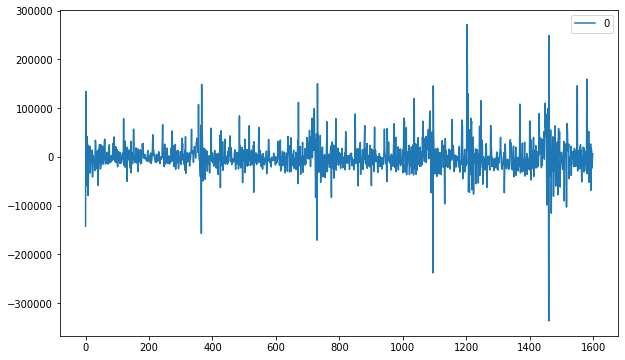

In [50]:
residuals = pd.DataFrame(arima_res.resid)
residuals.plot()


In [51]:
residuals.describe()

,0
count,1600.000000
mean,7.634180
std,31017.984080
min,-336642.698838
25%,-12592.085433
50%,-3326.663094
75%,10056.616979
max,271399.141713


Se hace la predicción y se grafica el intervalo de confianza

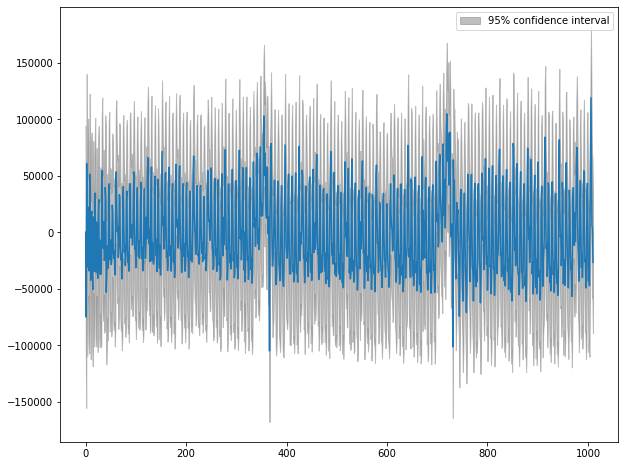

In [52]:
N = 1000
l = 10
fig, ax = plt.subplots(figsize=(10, 8))
plot_predict(arima_res, start=0, end=N + l, ax=ax)
plt.show()

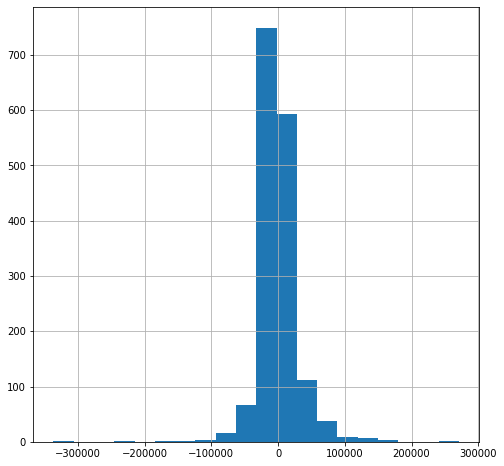

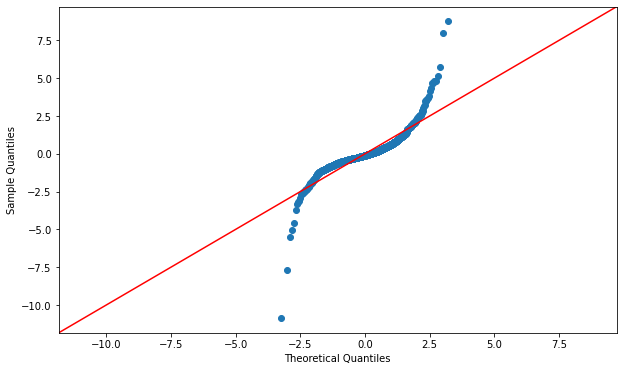

In [53]:

mean = np.mean(residuals.values.flatten())
std = np.std(residuals.values.flatten())

plt.show()
plt.figure(figsize=(8, 8))
plt.grid()
plt.hist(np.array(residuals.values.flatten()), bins=20)

fig = sm.qqplot((residuals.values.flatten() - mean) / std, line="45")


In [54]:
acorr_ljungbox(residuals, lags=[7], return_df=True)

,lb_stat,lb_pvalue
7,0.925188,0.995947


### Outliers

{'whiskers': [<matplotlib.lines.Line2D at 0x1c13207e020>,
 'caps': [<matplotlib.lines.Line2D at 0x1c13207c3d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c13207fc40>],
 'medians': [<matplotlib.lines.Line2D at 0x1c13207f160>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c13207eec0>],
 'means': []}

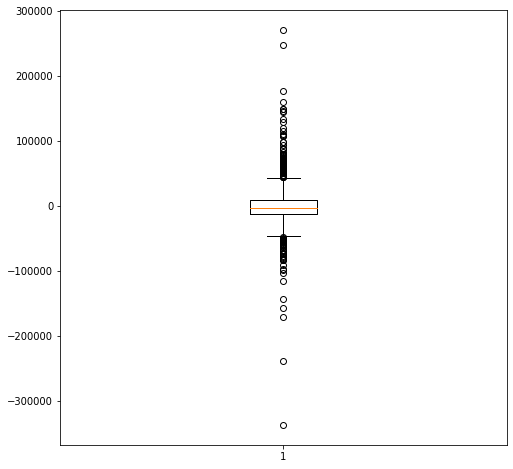

In [55]:
plt.figure(figsize=(8, 8))
plt.boxplot(residuals)

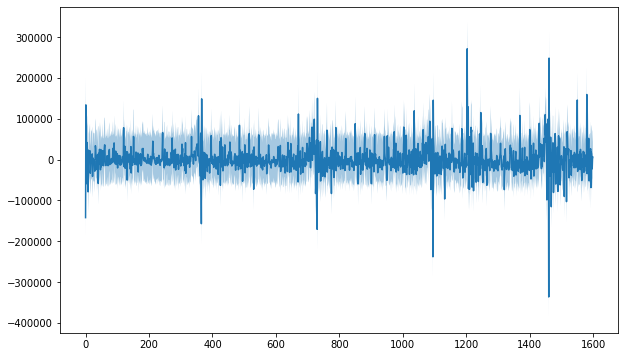

In [56]:
q975 = residuals.quantile(0.975)
q025 = residuals.quantile(0.025)
plt.plot(residuals)
plt.fill_between(
    x=residuals.index, 
    y1=(residuals + q025).values.flatten(),
    y2=(residuals + q975).values.flatten(),
    #y1=q025,
    #y2=q975,
    alpha=0.4
)

### Forcasting

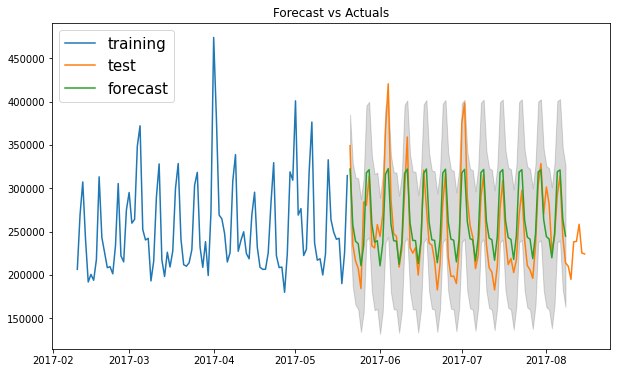

In [57]:
forecast = arima_res.get_forecast(80)
intervals = forecast.conf_int(alpha=0.05)


plt.plot((sales_per_day + tendency)[1500:], label='training')
plt.plot(sales_per_day_test, label='test')

fc_series = pd.Series(forecast.predicted_mean, index=sales_per_day_test.index[:len(forecast.predicted_mean)])
lower_series = pd.Series(intervals[:, 0], index=sales_per_day_test.index[:len(forecast.predicted_mean)])
upper_series = pd.Series(intervals[:, 1], index=sales_per_day_test.index[:len(forecast.predicted_mean)])

tendency_forecast_x = mdates.date2num(fc_series.index)
tendency_forecast_y = popt[0] * tendency_forecast_x + popt[1]

plt.plot(fc_series + tendency_forecast_y, label='forecast')
plt.fill_between(fc_series.index, lower_series + tendency_forecast_y, upper_series + tendency_forecast_y, color='k', alpha=.15)

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=15)
plt.show()


In [58]:
# import copy
# d = 1 
# q = 1
# p = 1

# n_predictions = 80
# predictions = []
# data = copy.copy(sales_per_day.values)
# for _ in range(n_predictions):
#     arima = ARIMA(data, order=(p, d, q))
#     arima_res = arima.fit()
#     forecast = arima_res.get_forecast(1)
#     data = np.append(data, forecast.predicted_mean)
#     #data = np.delete(data, 0)
#     predictions.append(forecast.predicted_mean)
    
    

In [59]:
# plt.plot((sales_per_day + tendency)[1500:], label='training')
# plt.plot(sales_per_day_test, label='test')

# fc_series = pd.Series(predictions, index=sales_per_day_test.index[:len(predictions)])

# tendency_forecast_x = mdates.date2num(fc_series.index)
# tendency_forecast_y = popt[0] * tendency_forecast_x + popt[1]

# plt.plot(fc_series + tendency_forecast_y, label='forecast')
# plt.fill_between(fc_series.index, lower_series + tendency_forecast_y, upper_series + tendency_forecast_y, color='k', alpha=.15)

# plt.title('Forecast vs Actuals')
# plt.legend(loc='upper left', fontsize=15)
# plt.show()

### SARIMA

In [60]:
grid = [
    ((1, 0 ,1), (1, 0, 1, 7)),
    ((2, 0 ,1), (1, 0, 2, 7)),
    ((4, 0 ,4), (4, 0, 4, 7)),
    ((1, 0 ,1), (1, 0, 2, 7)),
    ((1, 1 ,1), (1, 1, 1, 7))
]

In [61]:
def sarima_grid_search(values, grid):
    results = []
    for normal, seasonal in grid:
        model_sarima = sm.tsa.statespace.SARIMAX(
            values, 
            order=normal, 
            seasonal_order=seasonal, 
            enforce_stationarity=False, 
            enforce_invertibility=False
        )
        sarima_res = model_sarima.fit()
        results.append(sarima_res.bic)
    return grid[results.index(max(results))]

In [63]:
parameters = sarima_grid_search(sales_per_day.values, grid)
parameters

c:\Users\gonza\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


((1, 0, 1), (1, 0, 1, 7))

In [74]:
exog = np.array([0 for _ in range(len(sales_per_day.values))])

In [76]:
for i in range(len(exog)):
    if i % 365 == 0:
        exog[i] = 1


In [85]:
model_sarima = sm.tsa.statespace.SARIMAX(sales_per_day.values, exog=exog, order=parameters[0], seasonal_order=parameters[1], enforce_stationarity=False, enforce_invertibility=False)
sarima_res = model_sarima.fit()
print(sarima_res.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1600
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood              -18660.841
Date:                           Sun, 19 Jun 2022   AIC                          37333.682
Time:                                   17:48:07   BIC                          37365.915
Sample:                                        0   HQIC                         37345.654
                                          - 1600                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -1.941e+05   7345.876    -26.423      0.000   -2.08e+05    -1.8e+05
ar.L1          0.6687      0.038     17.814

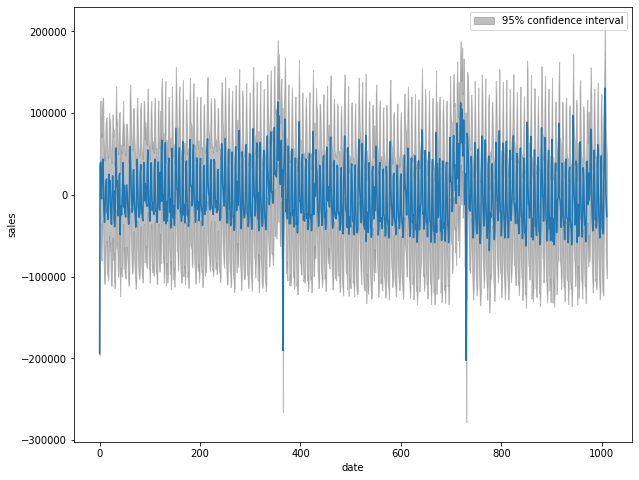

In [86]:
N = 1000
l = 10
fig, ax = plt.subplots(figsize=(10, 8))
plt.xlabel("date")
plt.ylabel("sales")
plot_predict(sarima_res, start=0, end=N + l, ax=ax)
plt.show()

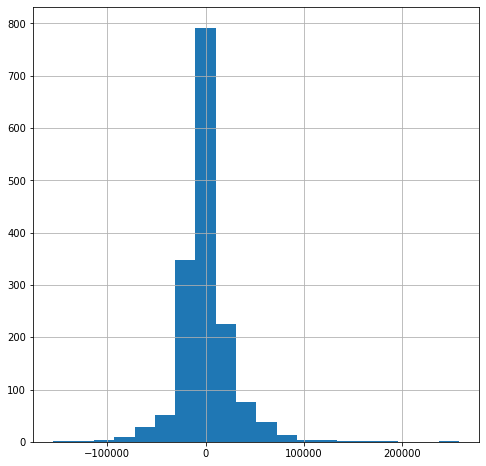

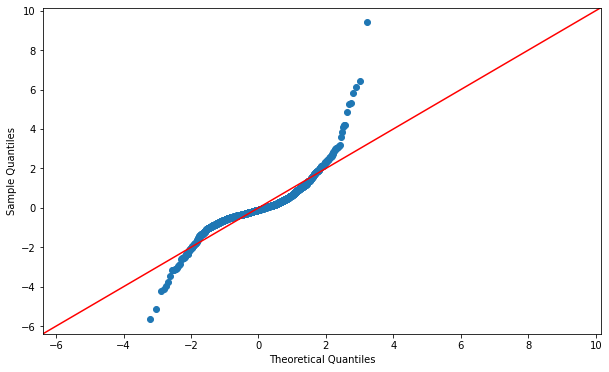

In [87]:

mean = np.mean(residuals_sarima.values.flatten())
std = np.std(residuals_sarima.values.flatten())

plt.show()
plt.figure(figsize=(8, 8))
plt.grid()
plt.hist(np.array(residuals_sarima.values.flatten()), bins=20)

fig = sm.qqplot((residuals_sarima.values.flatten() - mean) / std, line="45")

In [88]:
acorr_ljungbox(residuals_sarima, lags=[7], return_df=True)

,lb_stat,lb_pvalue
7,15.00944,0.035879


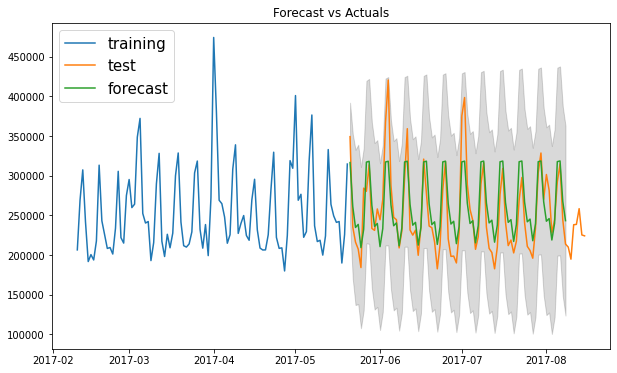

In [91]:
forecast = sarima_res.get_forecast(80, exog=np.zeros(80))
intervals = forecast.conf_int(alpha=0.05)


plt.plot((sales_per_day + tendency)[1500:], label='training')
plt.plot(sales_per_day_test, label='test')

fc_series = pd.Series(forecast.predicted_mean, index=sales_per_day_test.index[:len(forecast.predicted_mean)])
lower_series = pd.Series(intervals[:, 0], index=sales_per_day_test.index[:len(forecast.predicted_mean)])
upper_series = pd.Series(intervals[:, 1], index=sales_per_day_test.index[:len(forecast.predicted_mean)])

tendency_forecast_x = mdates.date2num(fc_series.index)
tendency_forecast_y = popt[0] * tendency_forecast_x + popt[1]

plt.plot(fc_series + tendency_forecast_y, label='forecast')
plt.fill_between(fc_series.index, lower_series + tendency_forecast_y, upper_series + tendency_forecast_y, color='k', alpha=.15)

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=15)
plt.show()

<AxesSubplot:>

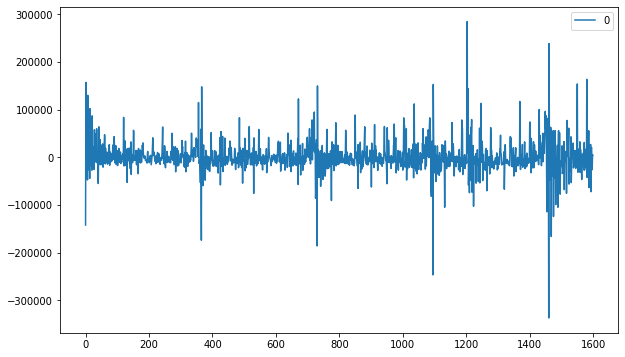

In [ ]:
residuals = pd.DataFrame(sarima_res.resid)
residuals.plot()

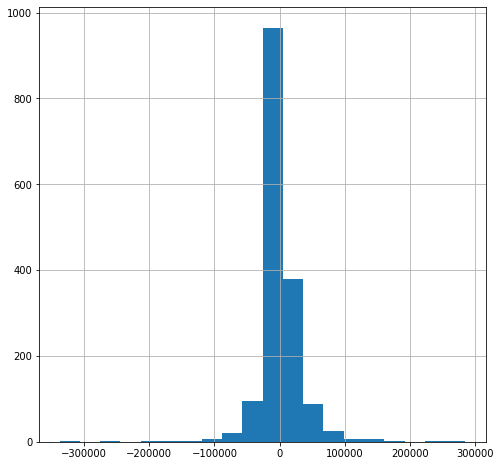

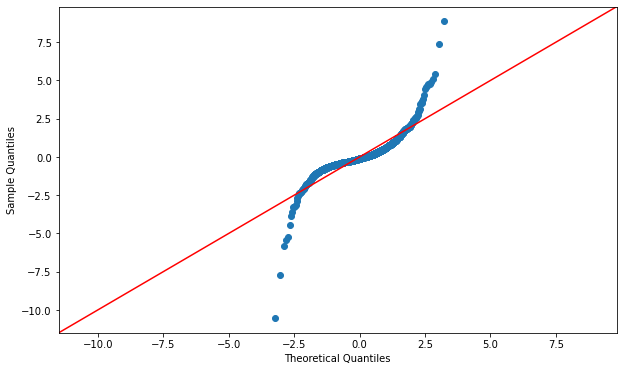

In [ ]:
mean = np.mean(residuals.values.flatten())
std = np.std(residuals.values.flatten())

plt.show()
plt.figure(figsize=(8, 8))
plt.grid()
plt.hist(np.array(residuals.values.flatten()), bins=20)

fig = sm.qqplot((residuals.values.flatten() - mean) / std, line="45")

### Modelado de las distintas frecuencias

In [ ]:
d = 0
q = 7
p = 10

high_freq_model = ARIMA(high_filtered_data, order=(p, d, q))
#high_freq_model = sm.tsa.statespace.SARIMAX(high_filtered_data, order=(1, 0, 1), seasonal_order=(1, 0, 1, 14), enforce_stationarity=False, enforce_invertibility=False)
high_freq_model_res = high_freq_model.fit()
print(high_freq_model_res.summary())

c:\Users\gonza\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1600
Model:                ARIMA(10, 0, 7)   Log Likelihood              -11254.087
Date:                Sat, 18 Jun 2022   AIC                          22546.174
Time:                        14:37:00   BIC                          22648.351
Sample:                             0   HQIC                         22584.116
                               - 1600                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.9995      3.378      2.368      0.018       1.379      14.620
ar.L1         -4.8563      0.018   -271.837      0.000      -4.891      -4.821
ar.L2        -11.3253      0.068   -166.403      0.0

In [ ]:
band_freq_model = sm.tsa.statespace.SARIMAX(filtered_data, order=(6, 0, 6), seasonal_order=(6, 0, 6 ,7), enforce_stationarity=False, enforce_invertibility=False)
band_freq_model_res = band_freq_model.fit()
print(band_freq_model_res.summary())

c:\Users\gonza\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1600
Model:             SARIMAX(6, 0, 6)x(6, 0, 6, 7)   Log Likelihood              -20056.335
Date:                           Sat, 18 Jun 2022   AIC                          40162.671
Time:                                   16:36:29   BIC                          40296.337
Sample:                                        0   HQIC                         40212.383
                                          - 1600                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6042      1.326      0.456      0.649      -1.994       3.202
ar.L2         -3.9670      2.026     -1.958

In [ ]:
d = 0
q = 17
p = 8

low_freq_model = ARIMA(low_filtered_data, order=(p, d, q))
low_freq_model_res = low_freq_model.fit()
print(low_freq_model_res.summary())

c:\Users\gonza\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\gonza\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1600
Model:                ARIMA(8, 0, 17)   Log Likelihood               -1772.155
Date:                Sat, 18 Jun 2022   AIC                           3598.309
Time:                        14:37:24   BIC                           3743.509
Sample:                             0   HQIC                          3652.227
                               - 1600                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -121.0135      0.651   -185.917      0.000    -122.289    -119.738
ar.L1         -0.3010      0.003    -95.292      0.000      -0.307      -0.295
ar.L2          0.3697      0.003    125.543      0.0

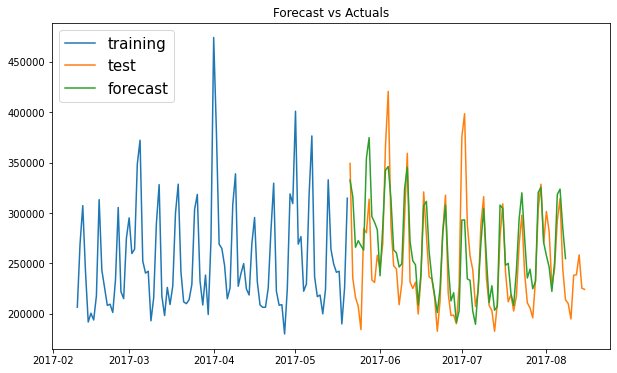

In [ ]:
n_forecast = 80
# forecast = low_freq_model_res.get_forecast(n_forecast).predicted_mean + 
#             band_freq_model_res.get_forecast(n_forecast).predicted_mean + 
#             high_freq_model_res.get_forecast(n_forecast).predicted_mean


#forecast = low_freq_model_res.get_forecast(n_forecast).predicted_mean + band_freq_model_res.get_forecast(n_forecast).predicted_mean
forecast = high_freq_model_res.get_forecast(n_forecast).predicted_mean + band_freq_model_res.get_forecast(n_forecast).predicted_mean + low_freq_model_res.get_forecast(n_forecast).predicted_mean
#forecast = low_freq_model_res.get_forecast(n_forecast).predicted_mean

plt.plot((sales_per_day + tendency)[1500:], label='training')
plt.plot(sales_per_day_test, label='test')

fc_series = pd.Series(forecast, index=sales_per_day_test.index[:len(forecast)])

tendency_forecast_x = mdates.date2num(fc_series.index)
tendency_forecast_y = popt[0] * tendency_forecast_x + popt[1]

plt.plot(fc_series + tendency_forecast_y, label='forecast')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=15)
plt.show()

### LSTM

In [ ]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_dataset = scaler.fit_transform(sales_per_day.values.reshape((len(sales_per_day.values), 1)))
test_dataset = scaler.transform(sales_per_day_test.values.reshape((len(sales_per_day_test.values), 1)))

In [ ]:

def create_dataset(dataset, look_back=10):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
look_back = 365
trainX, trainY = create_dataset(train_dataset, look_back=look_back)
#testX, testY = create_dataset(test_dataset, look_back=look_back)

In [ ]:
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [ ]:
model = Sequential()
model.add(LSTM(5, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


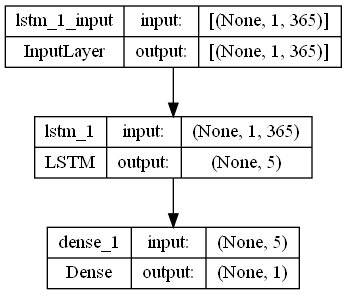

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(trainX, trainY, epochs=15, batch_size=1, verbose=2)

Epoch 1/15
1234/1234 - 4s - loss: 0.0062 - 4s/epoch - 3ms/step
Epoch 2/15
1234/1234 - 2s - loss: 0.0053 - 2s/epoch - 2ms/step
Epoch 3/15
1234/1234 - 2s - loss: 0.0049 - 2s/epoch - 2ms/step
Epoch 4/15
1234/1234 - 2s - loss: 0.0042 - 2s/epoch - 2ms/step
Epoch 5/15
1234/1234 - 2s - loss: 0.0041 - 2s/epoch - 2ms/step
Epoch 6/15
1234/1234 - 3s - loss: 0.0039 - 3s/epoch - 2ms/step
Epoch 7/15
1234/1234 - 3s - loss: 0.0039 - 3s/epoch - 2ms/step
Epoch 8/15
1234/1234 - 3s - loss: 0.0037 - 3s/epoch - 2ms/step
Epoch 9/15
1234/1234 - 2s - loss: 0.0038 - 2s/epoch - 2ms/step
Epoch 10/15
1234/1234 - 2s - loss: 0.0038 - 2s/epoch - 2ms/step
Epoch 11/15
1234/1234 - 2s - loss: 0.0037 - 2s/epoch - 2ms/step
Epoch 12/15
1234/1234 - 2s - loss: 0.0034 - 2s/epoch - 2ms/step
Epoch 13/15
1234/1234 - 3s - loss: 0.0036 - 3s/epoch - 2ms/step
Epoch 14/15
1234/1234 - 3s - loss: 0.0033 - 3s/epoch - 2ms/step
Epoch 15/15
1234/1234 - 2s - loss: 0.0032 - 2s/epoch - 2ms/step


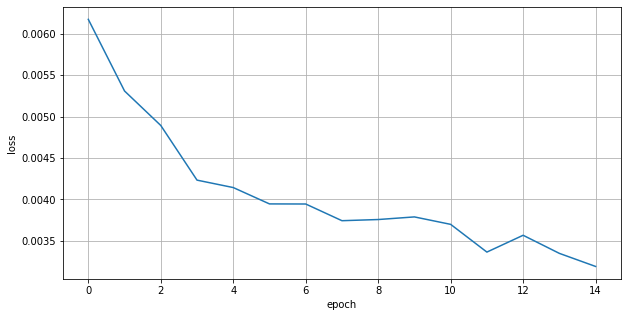

In [ ]:
plt.figure(figsize=(10, 5))
plt.grid()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(history.history['loss'])

In [ ]:
import copy
number_predictions = 60
predictions = []
aux_array = np.concatenate((copy.copy(trainX[-1]).squeeze()[1:], np.array([trainY[-1]])))
for _ in range(number_predictions):
    aux_array.resize(1, 1, look_back)
    prediction = model.predict(aux_array, verbose=0)
    predictions.append(prediction[-1])
    aux_array = aux_array.squeeze()
    aux_array[:-1] = aux_array[1:]; aux_array[-1] = prediction.squeeze()


In [ ]:
sales_per_day.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-05-11', '2017-05-12', '2017-05-13', '2017-05-14',
               '2017-05-15', '2017-05-16', '2017-05-17', '2017-05-18',
               '2017-05-19', '2017-05-20'],
              dtype='datetime64[ns]', name='date', length=1600, freq=None)

In [ ]:
sales_per_day_test.index

DatetimeIndex(['2017-05-21', '2017-05-22', '2017-05-23', '2017-05-24',
               '2017-05-25', '2017-05-26', '2017-05-27', '2017-05-28',
               '2017-05-29', '2017-05-30', '2017-05-31', '2017-06-01',
               '2017-06-02', '2017-06-03', '2017-06-04', '2017-06-05',
               '2017-06-06', '2017-06-07', '2017-06-08', '2017-06-09',
               '2017-06-10', '2017-06-11', '2017-06-12', '2017-06-13',
               '2017-06-14', '2017-06-15', '2017-06-16', '2017-06-17',
               '2017-06-18', '2017-06-19', '2017-06-20', '2017-06-21',
               '2017-06-22', '2017-06-23', '2017-06-24', '2017-06-25',
               '2017-06-26', '2017-06-27', '2017-06-28', '2017-06-29',
               '2017-06-30', '2017-07-01', '2017-07-02', '2017-07-03',
               '2017-07-04', '2017-07-05', '2017-07-06', '2017-07-07',
               '2017-07-08', '2017-07-09', '2017-07-10', '2017-07-11',
               '2017-07-12', '2017-07-13', '2017-07-14', '2017-07-15',
      

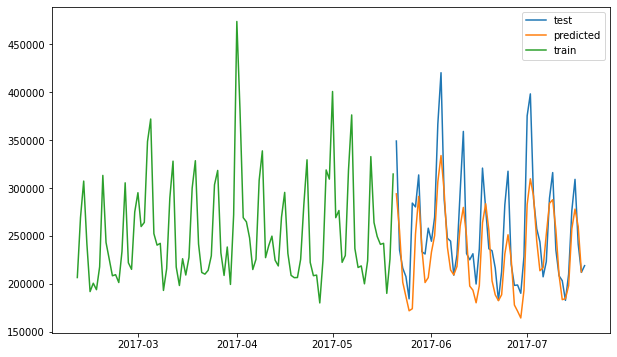

In [ ]:


plt.plot(sales_per_day_test[:number_predictions], label='test')
prediction_series = pd.Series(scaler.inverse_transform(predictions).squeeze()[1:], index=sales_per_day_test.index[:len(predictions)][:-1])

tendency_forecast_x = mdates.date2num(prediction_series.index)
tendency_forecast_y = popt[0] * tendency_forecast_x + popt[1]

plt.plot(prediction_series + tendency_forecast_y, label='predicted')
plt.plot((sales_per_day + tendency)[-100:], label='train')
plt.legend()